# Train- Data Loading

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision
from torchvision import transforms


## Train and Validation Dataset

In [38]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [39]:
# /content/gdrive/MyDrive/Colab Notebooks/Dataset/Processed.zip

In [40]:
!unzip -q -o /content/gdrive/MyDrive/Colab\ Notebooks/Dataset/Processed.zip -d datasets


#### Loading npy files

In [41]:
def load_file(path):
  return np.load(path).astype(np.float32)

In [42]:
train_transforms = transforms.Compose([
    # transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize(0.49, 0.248),
    transforms.RandomAffine(degrees=(-5,5), translate=(0, 0.05), scale=(0.9, 1.1)),
    transforms.RandomResizedCrop((224,224), scale=(0.35, 1))
])

In [43]:
val_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.49, 0.248)
])

In [44]:
train_dataset = torchvision.datasets.DatasetFolder("/content/datasets/train/", loader=load_file, extensions="npy", transform=train_transforms)

In [45]:
val_dataset = torchvision.datasets.DatasetFolder("/content/datasets/val/", loader=load_file, extensions="npy", transform=val_transforms)

In [46]:
type(train_dataset)

torchvision.datasets.folder.DatasetFolder

### Display Images

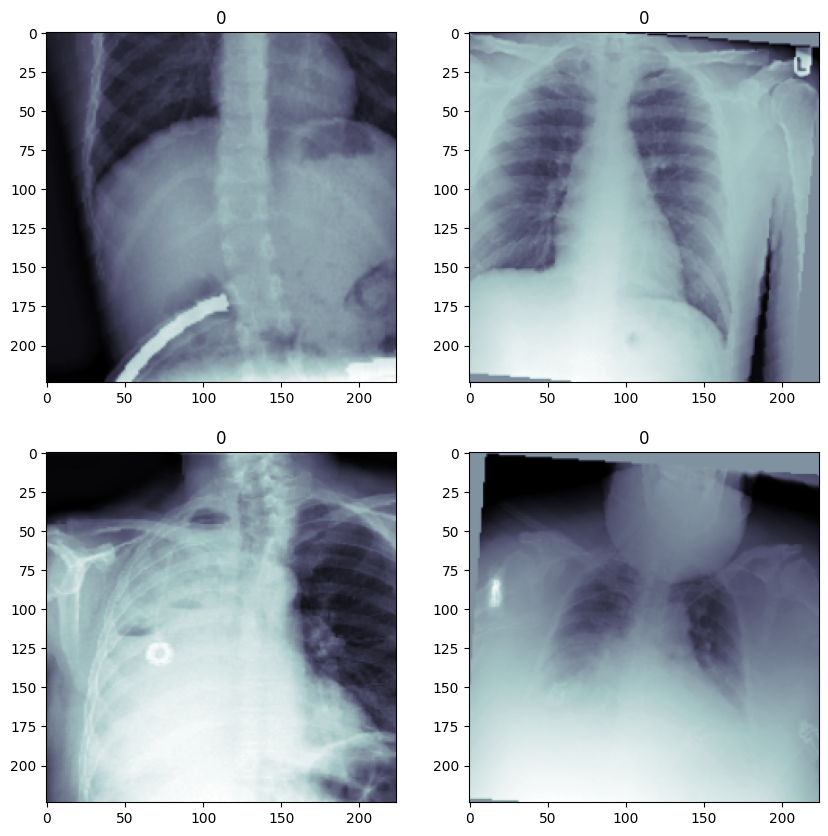

In [47]:
fig, axis = plt.subplots(2,2, figsize=(10,10))

for row in range(2):
  for column in range(2):
    random_index = np.random.randint(0,24000)
    x_ray, label = train_dataset[random_index]    # tuple unpacking
    axis[row][column].imshow(x_ray[0,:,:], cmap="bone")
    axis[row][column].set_title(label)


### Data Loader

In [48]:
batch_size = 64

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [49]:
np.unique(train_dataset.targets, return_counts=True)

(array([0, 1]), array([18593,  5407]))

# Define Model

In [50]:
torchvision.models.resnet18()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [79]:
# Change Input and Output shape

class PneumoniaModel(nn.Module):

  def __init__(self):
    super().__init__()
    self.model = torchvision.models.resnet18()
    self.model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7,7), stride=(2,2), padding=(3, 3), bias=False)
    self.model.fc = torch.nn.Linear(in_features=512, out_features=1, bias=True)

    # Optimizer and Loss
    # self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-4)
    # self.loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor([3]))

    # Trackers
    self.train_losses = []
    self.test_losses = []
    self.train_correct = []
    self.test_correct = []

  def forward(self, X):
    pred = self.model(X)
    return pred

In [80]:
model = PneumoniaModel()

In [81]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
# loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor([3]))
loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor([3]))

## Train Model

In [ ]:
import time

start_time = time.time()

Epochs = 1

# for loop Epochs
for epoch in range(Epochs):

  trn_corr = 0
  tst_corr = 0

  # Train
  for btch,(X_train, y_train) in enumerate(train_loader):

    y_pred = model(X_train)

    y_train = y_train.float()
    loss = loss_fn(y_pred, y_train.view(64,1))
    predicted = torch.Tensor(np.where(y_pred > 0.5, 1, 0))
    batch_corr = (predicted==y_train.view(64,1)).sum()
    trn_corr += batch_corr

    # Backward propagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if btch%10 == 0:
      print(f"EPOCH: {epoch+1} BATCH: {btch} LOSS: {loss.item()}")

  model.train_losses.append(loss)
  model.train_correct.append(trn_corr)


  # Test
  with torch.no_grad():
    for btch,(X_test,y_test) in enumerate(val_loader):

      y_val = model(X_test)
      predicted = torch.Tensor(np.where(y_val > 0.5, 1, 0))
      batch_corr = (predicted == y_test).sum()
      tst_corr += batch_corr

  loss = loss_fn(y_val, y_test.view(64,1))
  model.test_losses.append(loss)
  model.test_correct.append(tst_corr)



current_time = time.time()
total_time = current_time - start_time
print(f"Training took {total_time/60} minutest")
